In [53]:
import torch
import numpy as np
from mlp_mixer2D import MLPMixer2D

import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score, f1_score
from torchvision import models
import pandas as pd
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR


DataLoader

In [2]:
#pip install scikit-learn
#!pip install numpy
#pip install 
#!pip install pydicom
#!pip install matplotlib
#!pip install pandas
#pip install tqdm

DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [25]:
class DICOMDataset2(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.records = self._load_records()        
    
    def _load_records(self):
        records = []
        
        # 'echo' 디렉토리 내의 레이블 디렉토리 ('not_mi_f', 'mi_f') 매핑
        labels_dirs = {
            'MI_F_echo': 1, 
            'MI_M_echo': 1,
            'NOT_MI_F_echo': 0,
            'NOT_MI_M_echo': 0
        }
        
        # 'echo' 디렉토리 경로
        echo_dir = os.path.join(self.root_dir)

        for label, index in labels_dirs.items():
            label_dir = os.path.join(echo_dir, label)
            
            # 주어진 레이블 디렉토리에 대한 환자 디렉토리 탐색
            if not os.path.isdir(label_dir):
                print(f"Directory not found: {label_dir}")
                continue
            
            # 환자 디렉토리 내에서 DICOM 파일을 탐색
            for root, dirs, files in os.walk(label_dir):
                for file in files:
                    if file.lower().endswith('.dcm'):
                        file_path = os.path.join(root, file)
                        records.append((file_path, index))

        return records


    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        file_path, label = self.records[idx]
        dicom = pydicom.dcmread(file_path)
        
        # 멀티프레임 이미지인 경우 중간 프레임을 선택
        frame = dicom.pixel_array
        if 'NumberOfFrames' in dicom:
            middle_frame_index = dicom.NumberOfFrames // 2
            frame = frame[middle_frame_index]

        # 이미지 정규화 및 8비트 변환
        frame = np.clip((frame - np.min(frame)) / (np.max(frame) - np.min(frame)) * 255, 0, 255).astype(np.uint8)
        
        # PIL 이미지로 변환
        img = Image.fromarray(frame).convert('RGB')

        if self.transform:
            img = self.transform(img)
        
        return img, label


In [30]:
# 데이터 전처리 및 데이터셋 정의
'''transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(contrast=2.0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])'''

# PyTorch transforms를 정의합니다.
transform = transforms.Compose([          
    transforms.Resize((224, 224)),    # 이미지 크기 변경
    transforms.ColorJitter(contrast=2.0), # 대비 조정을 통한 데이터 증강
    transforms.ToTensor(),             # PIL 이미지를 PyTorch 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 정규화
    # 추가적인 전처리 단계를 여기에 포함할 수 있습니다.
])

root_dir = 'C:/Users/hongi/Desktop/echo'  # 수정: DICOM 파일이 저장된 최상위 디렉토리로 변경
dataset = DICOMDataset2(root_dir=root_dir, transform=transform)

# 데이터셋 사용 예시
# DataLoader를 생성하여 훈련 과정에서 사용할 수 있습니다.
# 예: train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [31]:
print(len(dataset))

1742


데이터 개수 확인 코드

In [32]:
'''import os

# 기준이 되는 ecg 파일과 확인해야 하는 echo 파일의 루트 디렉토리 경로
ecg_root = 'C:/Users/hongi/Desktop/MI_M_ecg (1).zip/MI_M_ecg'
echo_root = 'C:/Users/hongi/Desktop/echo/MI_M_echo'

# ECG 디렉토리의 가장 하위 디렉토리를 찾습니다.
for root, dirs, files in os.walk(ecg_root):
    if not dirs:  # 더 이상 하위 디렉토리가 없는 경우, 즉 가장 하위 디렉토리입니다.
        relative_path = os.path.relpath(root, ecg_root)  # ecg_root로부터의 상대 경로
        corresponding_echo_path = os.path.join(echo_root, relative_path)
        
        # 해당 경로가 ECHO 디렉토리 내에 존재하는지 확인합니다.
        if os.path.isdir(corresponding_echo_path):
            dcm_files = [file for file in os.listdir(corresponding_echo_path) if file.lower().endswith('.dcm')]
            if not dcm_files:  # 해당 가장 하위 디렉토리에 .dcm 파일이 없는 경우
                print(f"No .dcm files found in ECHO corresponding to ECG path: {corresponding_echo_path}")
        else:
            print(f"Corresponding ECHO path does not exist for ECG path: {corresponding_echo_path}")'''

'import os\n\n# 기준이 되는 ecg 파일과 확인해야 하는 echo 파일의 루트 디렉토리 경로\necg_root = \'C:/Users/hongi/Desktop/MI_M_ecg (1).zip/MI_M_ecg\'\necho_root = \'C:/Users/hongi/Desktop/echo/MI_M_echo\'\n\n# ECG 디렉토리의 가장 하위 디렉토리를 찾습니다.\nfor root, dirs, files in os.walk(ecg_root):\n    if not dirs:  # 더 이상 하위 디렉토리가 없는 경우, 즉 가장 하위 디렉토리입니다.\n        relative_path = os.path.relpath(root, ecg_root)  # ecg_root로부터의 상대 경로\n        corresponding_echo_path = os.path.join(echo_root, relative_path)\n        \n        # 해당 경로가 ECHO 디렉토리 내에 존재하는지 확인합니다.\n        if os.path.isdir(corresponding_echo_path):\n            dcm_files = [file for file in os.listdir(corresponding_echo_path) if file.lower().endswith(\'.dcm\')]\n            if not dcm_files:  # 해당 가장 하위 디렉토리에 .dcm 파일이 없는 경우\n                print(f"No .dcm files found in ECHO corresponding to ECG path: {corresponding_echo_path}")\n        else:\n            print(f"Corresponding ECHO path does not exist for ECG path: {corresponding_echo_path}")'

In [33]:
# 첫 번째 이미지와 레이블을 데이터셋에서 불러오기
img, label = dataset[0]

# 이미지의 타입 출력
print("Image Type:", type(img))

# 이미지의 차원과 타입 확인
if hasattr(img, 'shape'):
    print("Image Shape:", img.shape)
elif hasattr(img, 'size'):
    print("Image Size:", img.size())

# 이미지의 픽셀 값 범위 확인 (옵션)
if hasattr(img, 'min') and hasattr(img, 'max'):
    print("Pixel Value Range:", img.min(), "-", img.max())


Image Type: <class 'torch.Tensor'>
Image Shape: torch.Size([3, 224, 224])
Pixel Value Range: tensor(-2.1179) - tensor(2.2489)


In [19]:
'''# DICOM 파일의 경로를 지정하세요
dicom_file_path = 'C:/Users/hongi/Downloads/echo/NOT_MI_F_echo (1)/NOT_MI_F_echo/p18/p18758318/90970660_0001.dcm'

# 파일 로드
dicom_data = pydicom.dcmread(dicom_file_path)

# DICOM 파일의 메타데이터 출력
print(dicom_data)

# 픽셀 데이터의 속성 확인
print("Shape of Pixel Data:", dicom_data.pixel_array.shape)
print("Data Type of Pixel Data:", dicom_data.pixel_array.dtype)'''


'import pydicom\n\n# DICOM 파일의 경로를 지정하세요\ndicom_file_path = \'C:/Users/hongi/Downloads/echo/NOT_MI_F_echo (1)/NOT_MI_F_echo/p18/p18758318/90970660_0001.dcm\'\n\n# 파일 로드\ndicom_data = pydicom.dcmread(dicom_file_path)\n\n# DICOM 파일의 메타데이터 출력\nprint(dicom_data)\n\n# 픽셀 데이터의 속성 확인\nprint("Shape of Pixel Data:", dicom_data.pixel_array.shape)\nprint("Data Type of Pixel Data:", dicom_data.pixel_array.dtype)'

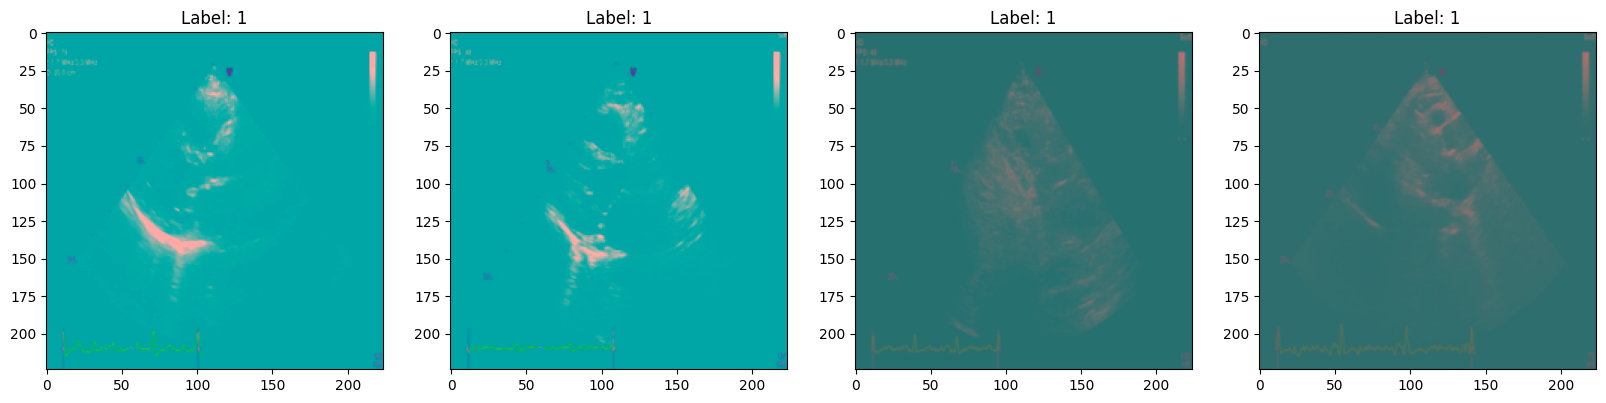

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    img, label = dataset[i]
    img = img.numpy().transpose((1, 2, 0))  # PyTorch 텐서를 numpy 배열로 변환하고, CHW를 HWC로 변경
    img = (img * 0.5 + 0.5)  # 정규화된 이미지를 [0, 1] 범위로 복원
    axes[i].imshow(img)
    axes[i].set_title(f'Label: {label}')  # 이미지의 제목으로 레이블을 표시
    axes
    
plt.show()


In [34]:
# 전체 데이터셋 크기 및 분할 비율 설정
total_size = len(dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.2 * total_size)
test_size = total_size - train_size - valid_size

# 데이터셋을 무작위로 분할
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)  # 검증 세트는 일반적으로 섞지 않지만 예시를 위해 shuffle=True 설정
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # 테스트 세트는 일반적으로 섞지 않음


In [35]:
print(len(train_dataset))  # 훈련 데이터셋의 크기
print(len(valid_dataset))    # 검증 데이터셋의 크기
print(len(test_dataset))   # 테스트 데이터셋의 크기

first_data_point, first_label = train_dataset[0]
print(first_data_point.shape)

# DataLoader에서 첫 번째 배치의 레이블을 확인하는 함수
def check_labels(data_loader, name):
    # DataLoader에서 첫 번째 배치를 가져옴
    first_batch = next(iter(data_loader))
    # 첫 번째 배치의 레이블을 가져옴
    labels = first_batch[1]
    print(f"{name} first batch labels: {labels}")

# 각 DataLoader에 대해 함수 호출
check_labels(train_loader, 'Train')
check_labels(valid_loader, 'Validation')
check_labels(test_loader, 'Test')


1219
348
175
torch.Size([3, 224, 224])
Train first batch labels: tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0])
Validation first batch labels: tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1])
Test first batch labels: tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1])


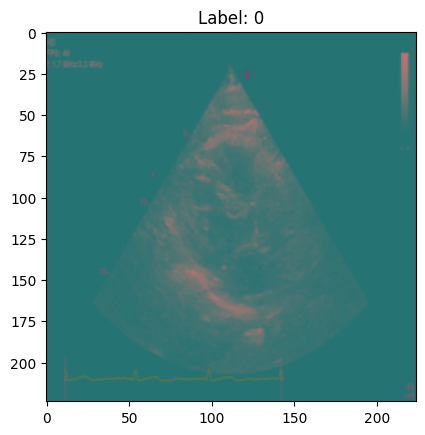

In [46]:
# 훈련 데이터셋에서 한 샘플을 불러옵니다.
img, label = train_dataset[20]

# 정규화된 이미지를 복원합니다. 만약 이미지가 [-1, 1] 범위로 정규화되었다면 아래와 같이 복원
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
img = img * std[:, None, None] + mean[:, None, None]  # 정규화 복원

# 이미지의 차원을 (채널, 높이, 너비)에서 (높이, 너비, 채널)로 변경하고 시각화합니다.
img = img.permute(1, 2, 0).numpy()  # 이미 텐서이므로 이 시점에서 permute를 수행합니다.
plt.imshow(img)
plt.title(f'Label: {label}')
plt.show()

resnet50


In [17]:

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define your save directory
save_dir = 'C:/Users/hongi/Desktop/MLP-Mixer-pytorch-master/24w_MI_Multimodal_Prediction/runs/'


# Define the ResNet-50 model
model_resnet50 = models.resnet50(pretrained=False)  # Load pre-trained ResNet-50
# Modify the final fully connected layer to match your classification task
num_classes = 2  # Replace with the number of classes in your dataset
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, num_classes)
model_resnet50.to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet50.parameters(), lr=0.00002)
from sklearn.metrics import accuracy_score
# Training loop
num_epochs = 100  # Replace with the number of epochs you want to train for

best_val_loss = float('inf')  # 검증 손실을 기준으로 최고 모델을 저장하기 위한 변수        
best_loss = 100
# 훈련 및 검증 손실과 정확도를 저장할 리스트 초기화
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    model_resnet50.train()  # Set the model to training mode
    running_loss = 0.0
    
    all_train_preds = []  # 에폭별 훈련 데이터의 예측값을 저장할 리스트
    all_train_labels = []  # 에폭별 훈련 데이터의 실제 레이블을 저장할 리스트
    

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model_resnet50(inputs)
        _, preds = torch.max(outputs, 1)  # 가장 높은 스코어를 가진 인덱스를 예측값으로 선택
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()  # 총 손실 계산 수정
        all_train_preds.extend(preds.cpu().numpy())  # 예측값 저장
        all_train_labels.extend(labels.cpu().numpy())  # 실제 레이블 저장
    
    
    # Validation loop
    model_resnet50.eval()
    all_preds = []
    all_labels = []
    val_running_loss=0.0
    
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet50(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 실제 라벨과 예측 라벨 출력
        print(f"Batch 실제 라벨: {labels.cpu().numpy()[:5]}, 예측 라벨: {preds.cpu().numpy()[:5]}")


    accuracy = accuracy_score(all_labels, all_preds)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    epoch_val_loss=val_running_loss / len(valid_loader)
    epoch_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs},train Loss: {epoch_train_loss},valid Loss: {epoch_val_loss}, Validation Accuracy: {accuracy * 100:.2f}%, Validation F1 Score: {f1 * 100:.2f}%")

    # 검증 손실이 이전 최소값보다 작으면 모델 저장
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        model_path = os.path.join(save_dir, 'resnet50_best.pth')
        torch.save(model_resnet50.state_dict(), model_path)
        print(f"Model saved to {model_path}")
        
     # 리스트에 손실과 정확도 추가
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_val_loss)
    train_accuracies.append(train_accuracy * 100)  # 훈련 정확도 추가
    valid_accuracies.append(accuracy * 100)  # 검증 정확도 추가



print("Training complete")

Epoch 1/100 - Validation: 100%|██████████| 9/9 [01:04<00:00,  7.16s/it]


Batch 실제 라벨: [1 0 1 1 1], 예측 라벨: [1 0 1 1 0]
Epoch 1/100,train Loss: 0.7031133770942688,valid Loss: 0.6948395238982307, Validation Accuracy: 48.23%, Validation F1 Score: 59.22%
Model saved to C:/Users/hongi/Desktop/MLP-Mixer-pytorch-master/24w_MI_Multimodal_Prediction/runs/resnet50_best.pth


Epoch 2/100 - Validation: 100%|██████████| 9/9 [01:04<00:00,  7.16s/it]


Batch 실제 라벨: [1 0 1 1 1], 예측 라벨: [1 1 1 1 1]
Epoch 2/100,train Loss: 0.6818729965917526,valid Loss: 0.6993528405825297, Validation Accuracy: 47.52%, Validation F1 Score: 61.46%


Epoch 3/100 - Validation: 100%|██████████| 9/9 [01:04<00:00,  7.20s/it]


Batch 실제 라벨: [1 0 0 0 1], 예측 라벨: [0 1 0 0 0]
Epoch 3/100,train Loss: 0.6592160155696254,valid Loss: 0.7119414210319519, Validation Accuracy: 51.06%, Validation F1 Score: 58.18%


Epoch 4/100 - Validation: 100%|██████████| 9/9 [01:04<00:00,  7.12s/it]


Batch 실제 라벨: [1 1 1 1 0], 예측 라벨: [1 1 1 1 1]
Epoch 4/100,train Loss: 0.6504072527731618,valid Loss: 0.8647947311401367, Validation Accuracy: 48.94%, Validation F1 Score: 65.05%


Epoch 5/100 - Validation: 100%|██████████| 9/9 [01:04<00:00,  7.21s/it]


Batch 실제 라벨: [0 0 1 1 0], 예측 라벨: [0 1 0 0 1]
Epoch 5/100,train Loss: 0.6232674698675832,valid Loss: 0.7058407134479947, Validation Accuracy: 53.19%, Validation F1 Score: 32.65%


Epoch 6/100 - Validation: 100%|██████████| 9/9 [01:04<00:00,  7.12s/it]


Batch 실제 라벨: [1 0 0 1 0], 예측 라벨: [1 1 1 1 1]
Epoch 6/100,train Loss: 0.5961878184349306,valid Loss: 0.7258055541250441, Validation Accuracy: 52.48%, Validation F1 Score: 53.15%


Epoch 7/100 - Validation: 100%|██████████| 9/9 [01:04<00:00,  7.17s/it]


Batch 실제 라벨: [1 0 0 0 0], 예측 라벨: [0 0 0 0 0]
Epoch 7/100,train Loss: 0.5792843161090728,valid Loss: 1.0687046845753987, Validation Accuracy: 51.77%, Validation F1 Score: 0.00%


Epoch 8/100 - Validation: 100%|██████████| 9/9 [01:04<00:00,  7.16s/it]


Batch 실제 라벨: [0 0 1 1 0], 예측 라벨: [0 0 0 1 0]
Epoch 8/100,train Loss: 0.5582810794153521,valid Loss: 0.749466081460317, Validation Accuracy: 51.06%, Validation F1 Score: 47.33%


Epoch 9/100 - Validation: 100%|██████████| 9/9 [01:25<00:00,  9.52s/it]


Batch 실제 라벨: [0 0 0 0 0], 예측 라벨: [1 1 1 1 1]
Epoch 9/100,train Loss: 0.5095988588948404,valid Loss: 1.0658907956547208, Validation Accuracy: 47.52%, Validation F1 Score: 64.08%


Epoch 10/100 - Validation: 100%|██████████| 9/9 [01:03<00:00,  7.06s/it]


Batch 실제 라벨: [0 0 0 0 0], 예측 라벨: [0 0 0 0 0]
Epoch 10/100,train Loss: 0.4615770847566666,valid Loss: 0.8372843464215597, Validation Accuracy: 49.65%, Validation F1 Score: 32.38%


Epoch 11/100 - Validation: 100%|██████████| 9/9 [01:03<00:00,  7.05s/it]


Batch 실제 라벨: [0 0 0 1 0], 예측 라벨: [0 0 0 0 0]
Epoch 11/100,train Loss: 0.46645101039640363,valid Loss: 1.6673089133368597, Validation Accuracy: 51.77%, Validation F1 Score: 0.00%


Epoch 12/100 - Validation: 100%|██████████| 9/9 [01:03<00:00,  7.04s/it]


Batch 실제 라벨: [0 0 0 1 0], 예측 라벨: [1 1 1 1 1]
Epoch 12/100,train Loss: 0.4278340233910468,valid Loss: 2.005115270614624, Validation Accuracy: 48.23%, Validation F1 Score: 65.07%


Epoch 13/100 - Validation: 100%|██████████| 9/9 [01:03<00:00,  7.05s/it]


Batch 실제 라벨: [1 1 0 0 0], 예측 라벨: [1 0 1 0 1]
Epoch 13/100,train Loss: 0.4385061441890655,valid Loss: 0.9282855656411912, Validation Accuracy: 50.35%, Validation F1 Score: 54.55%


Epoch 14/100 - Training:  23%|██▎       | 7/31 [01:09<03:57,  9.90s/it]


KeyboardInterrupt: 

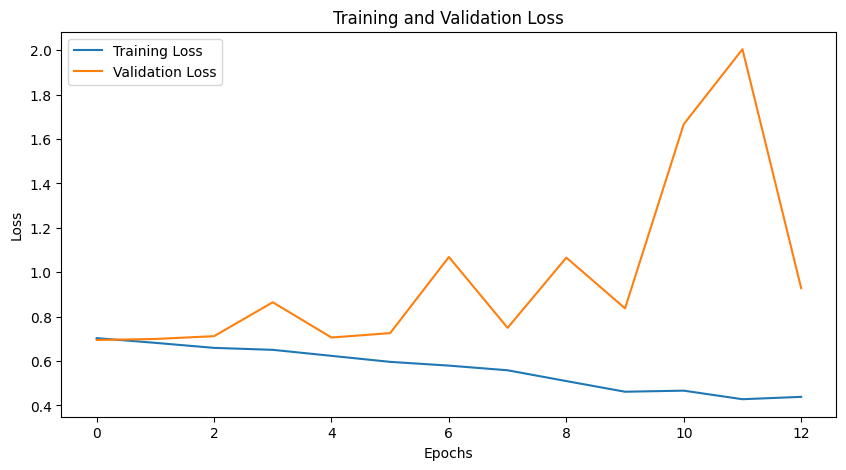

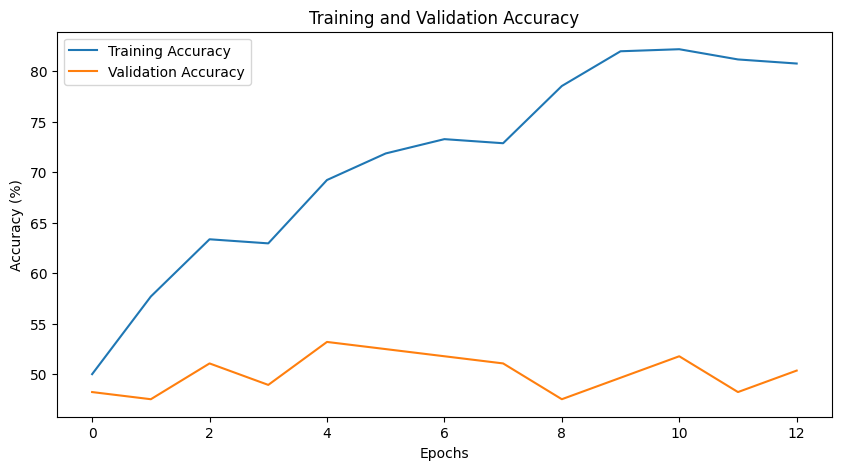

In [18]:
# 손실 그래프
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 정확도 그래프
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

model, loss func, optimizer

In [55]:

model = MLPMixer2D(in_channels=3, image_size=224, patch_size=56, num_classes=2,  # CIFAR-10 클래스 수
                 dim=512, depth=4, token_dim=256, channel_dim=2048).to(device)
#model = MlpMixer(num_channels=12, hidden_dim=64, mlp_token_dim=64,
# mlp_channel_dim=64, seq_len=5000, num_blocks=2, num_classes=2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
# 코사인 어닐링 스케줄러 설정
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0)  # 여기서 T_max는 주기, eta_min은 최소 학습률입니다.


train

In [50]:
print(torch.cuda.is_available())
print(torch.__version__)

False
1.11.0+cpu


In [67]:
#model = MlpMixer(num_channels=12, hidden_dim=64, mlp_token_dim=64, mlp_channel_dim=64, seq_len=5000, num_blocks=2, num_classes=2)

# GPU가 사용 가능한지 확인하고, 사용 가능하다면 GPU를 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 GPU로 이동시킵니다.

print(device)

cuda


In [56]:
from tqdm import tqdm
num_epochs = 50
best_val_accuracy = 0
patience = 50
stale_epochs = 0
train_losses = []  # 훈련 손실을 기록할 리스트
val_losses = []    # 검증 손실을 기록할 리스트
val_accuracies = []  # 검증 정확도를 기록할 리스트


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # 훈련 손실 로깅
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)  # 훈련 손실 기록
    #writer.add_scalar('Loss/train', epoch_loss, epoch)

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.5f}")

    # 검증 단계
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]'):
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_epoch_loss = val_running_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)  # 검증 손실 기록
    val_accuracies.append(val_accuracy)  # 검증 정확도 기록
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # 모델 가중치 저장
        torch.save(model.state_dict(), 'best_model_weights.pth')
        print(f"New best model saved with accuracy: {best_val_accuracy:.4f}%")
    
    print(f'Epoch {epoch+1}, Validation Loss: {val_epoch_loss:.5f}, Validation Accuracy: {val_accuracy:.4f}%')

    # 학습률 스케줄러 업데이트 (코사인 어닐링)
    scheduler.step()


#writer.close()
print('Finished Training')
print(f'Training Loss: {train_losses[-1]:.10f}')
print(f'Validation Loss: {val_losses[-1]:.10f}')
print(f'Validation Accuracy: {val_accuracies[-1]:.4f}%')

Epoch 1/50 [Training]: 100%|██████████| 77/77 [09:20<00:00,  7.28s/it]


Epoch 1, Training Loss: 0.85535


Epoch 1/50 [Validation]: 100%|██████████| 22/22 [02:40<00:00,  7.30s/it]


New best model saved with accuracy: 49.7126%
Epoch 1, Validation Loss: 0.77622, Validation Accuracy: 49.7126%


Epoch 2/50 [Training]:  65%|██████▍   | 50/77 [06:01<03:26,  7.64s/it]

In [ ]:

# 훈련 손실과 검증 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 검증 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()